In [20]:
%load_ext autoreload
%autoreload 2
#%matplotlib tk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import mesh
import random
import solver
import sympy
import math
import adaptation

### Problem Setup

We look to solving the Poisson Equation with an exponential as it's analytical solution. In particular, in this notebook, we are solving 

$$
\nabla^2 u(x,y) = f(x,y) \quad on \; \Omega = [-1, 1]\; x \; [-1, 1]
$$
$$
u = g_D \quad on \; \partial \Omega
$$

with 

$$
u_{analytical} = exp(5 \cdot (x + y)) \cdot sin(\pi x) \cdot sin(\pi y)
$$


#### Lambda Expression for $u_{analytical} (x,y)$

In [22]:
x_sympy, y_sympy = sympy.symbols('x y')
sympy.init_printing()

# Case : Exponential and Sin function
u_exact_sympy = sympy.exp(5*(x_sympy + y_sympy)) * sympy.sin(math.pi*x_sympy)*sympy.sin(math.pi*y_sympy)

# Lambdify the analytical solution:
u_analytical = sympy.lambdify((x_sympy, y_sympy), u_exact_sympy)

Text(0,0.5,'y')

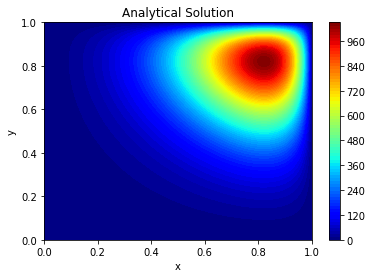

In [23]:

# Plot the exact solution
n_plot_vals = 100
x_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)
y_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)
x_plot_vals, y_plot_vals = np.meshgrid(x_plot_vals_1D, y_plot_vals_1D)

# Get the analytical solution
u_analytical_plot_vals = u_analytical(x_plot_vals, y_plot_vals)

plt.figure()
plt.contourf(x_plot_vals, y_plot_vals, u_analytical_plot_vals, 100, cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.title("Analytical Solution")
plt.xlabel("x")
plt.ylabel("y")

#plt.savefig(CONST_plot_output_dir + "analytical_solution.pdf")

#### Lambda Expression for $f(x,y)$

In [24]:

du_exact_dx_sympy = sympy.diff(u_exact_sympy, x_sympy)
du_exact_dy_sympy = sympy.diff(u_exact_sympy, y_sympy)

d2u_exact_dx2_sympy = sympy.diff(du_exact_dx_sympy, x_sympy)
d2u_exact_dy2_sympy = sympy.diff(du_exact_dy_sympy, y_sympy)

# Lambdify the RHS:
f_rhs_analytical = sympy.lambdify((x_sympy, y_sympy), d2u_exact_dx2_sympy + d2u_exact_dy2_sympy)

## Mesh Setup

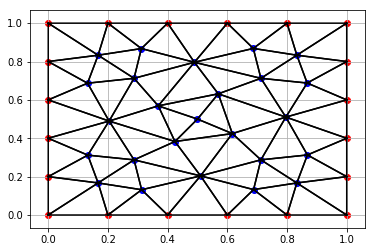

In [25]:
# Generate the mesh

p = 1

#gmsh_file_path = "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength1.0.msh"
#gmsh_file_path = "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.7.msh"
gmsh_file_path = "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.2.msh"
#gmsh_file_path = "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.1.msh"
#gmsh_file_path = "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.05.msh"

def dirichlet_bc_flag(x, y):
    if abs(x - 1.) < 1E-10 or abs(y - 1.) < 1E-10 or abs(x - 0.) < 1E-10 or abs(y - 0.) < 1E-10:
        return True, u_analytical(x,y)
    return False, None

mesh_properties = {
    "dirichlet_bc_flag": dirichlet_bc_flag
}

mesh_obj = mesh.TriMeshGMSH(p, mesh_properties, gmsh_file_path)

# Visualize the mesh
mesh_obj.plot_mesh()
plt.grid()

## Poisson Solver Setup

In [26]:

poisson_solver = solver.PoissonSolver(mesh_obj, f_rhs_analytical)


## Solve

In [27]:

# Assemble the LHS and RHS
poisson_solver.assemble_system()

# Solve the system
poisson_solver.solve_system()


## Postprocessing - Initial Solution
Post process the solution obtained on the initial mesh before we do any adaptation.

In [28]:

def visualize_numerical_analytical_solutions(mesh_obj, plot_mesh_bool=True):
    n_plot_vals = 50
    x_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)
    y_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)

    x_plot_vals, y_plot_vals, u_plot_vals = mesh_obj.project_solution(x_plot_vals_1D, y_plot_vals_1D, n_plot_vals)

    # Get the analytical solution
    u_analytical_plot_vals = u_analytical(x_plot_vals, y_plot_vals)
    
    color_bar_max = max(np.max(u_analytical_plot_vals), np.max(u_plot_vals))
    color_bar_min = min(np.min(u_analytical_plot_vals), np.min(u_plot_vals))
    color_bar_levels = np.linspace(color_bar_min, color_bar_max, 100)
    
    plt.figure(figsize=(17, 5))
    plt.subplot(1,2,1)
    plt.contourf(x_plot_vals, y_plot_vals, u_plot_vals, color_bar_levels, cmap=plt.get_cmap("jet"))
    plt.colorbar()
    plt.title("Numerical Solution")
    if plot_mesh_bool:
        mesh_obj.plot_mesh(plot_nodes=False, linewidth=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])

    plt.subplot(1,2,2)
    plt.contourf(x_plot_vals, y_plot_vals, u_analytical_plot_vals, color_bar_levels, cmap=plt.get_cmap("jet"))
    plt.colorbar()
    plt.title("Analytical Solution")
    
def visualize_error_indicator_field(mesh_obj):
   
    # Visualize the distribution of the error indicator
    n_plot_vals = 50
    x_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)
    y_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)

    x_plot_vals, y_plot_vals, e_plot_vals = mesh_obj.project_error_indicator(x_plot_vals_1D, y_plot_vals_1D, n_plot_vals)

    plt.figure()
    plt.contourf(x_plot_vals, y_plot_vals, e_plot_vals, 100, cmap=plt.get_cmap("jet"))
    plt.colorbar()
    plt.title("Error Indicator")
    mesh_obj.plot_mesh(plot_nodes=False, linewidth=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    

#### Compare the Numerical solution to the Analytical solution

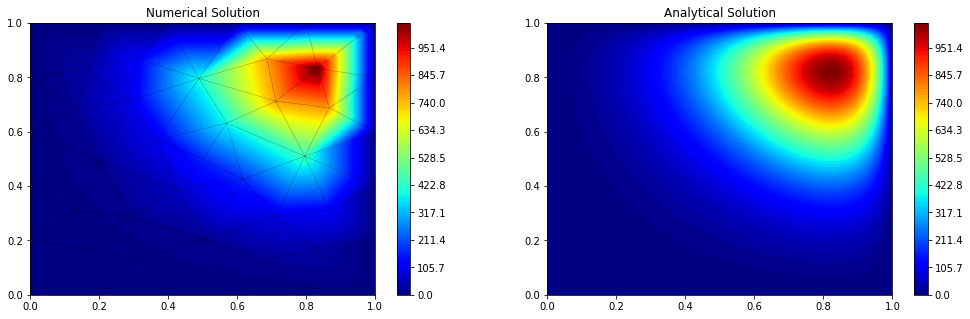

In [29]:

visualize_numerical_analytical_solutions(mesh_obj)


#### Compute and Visualize the error indicator
The error indicator is a measure of where the error is the highest. Therefore, those volumes with the highest values will effectively be chosen to be refined.

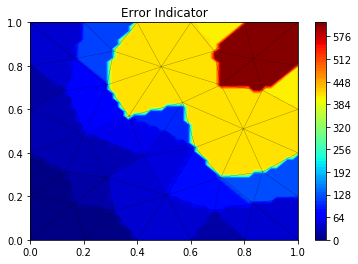

In [30]:

# Compute the error indicator using the solution. Visualize the
# distribution of the indicator.

# Implicit Residual Error Indicator
poisson_solver.compute_implicit_error_indicator()

visualize_error_indicator_field(mesh_obj)


## Adaptation Algorithm

### Adaptation Setup
Setup the structures that will be used to measure the effectiveness of the mesh adaptation.

In [31]:
adaptation_iteration = 0

# Store tuples of [ndof, global L2 error]
error_convergence = []
error_convergence_Linf = []

# - Store the initial error value
global_L2_error = poisson_solver.compute_L2_error(u_analytical)
error_convergence.append([len(mesh_obj.dof_list), global_L2_error])

global_Linf_error = poisson_solver.compute_Linf_error(u_analytical)
error_convergence_Linf.append([len(mesh_obj.dof_list), global_Linf_error])

### Adaptation Loop
The following cell is where adaptation will be completed. Rerun the cell as many times as desired (each time the cell is run one adaptation cycle is completed where the error is first estimated, elements with the highest error are marked and the mesh is refined). 

In practice this will typically be automated, where the user will describe a given error tolerance and the adaptation loop will then run and break when the error is below this value. In this notebook, we have not included this yet. Instead, the user can rerun the given cell a certain number of times to perform a certain number of refinement cycles.

NOTE: For this case, running the cell 4 times (performing 4 adaptation iterations) seems to be sufficient.

adaptation_iteration : 4 


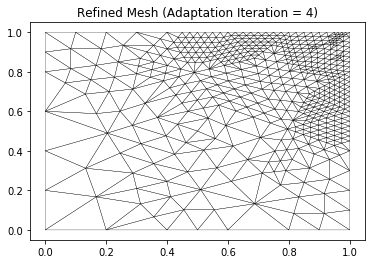

<Figure size 432x288 with 0 Axes>

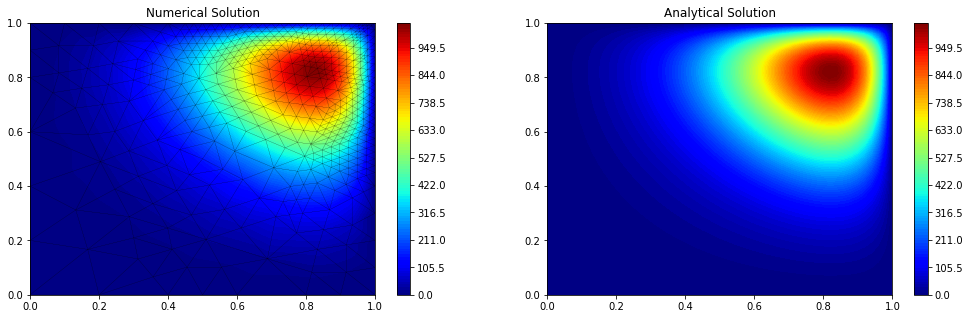

<Figure size 432x288 with 0 Axes>

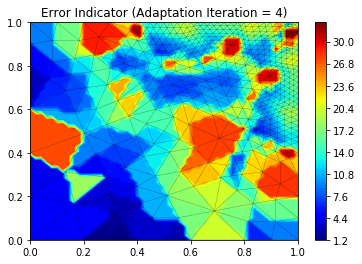

In [35]:

# Adapt all elements with error indicator greater than a certain amount
adaptation.h_adapt_mesh(mesh_obj, 0.5)

# Visualize the Refined Mesh
plt.figure()
mesh_obj.plot_mesh(plot_nodes=False, linewidth=0.3)
plt.title("Refined Mesh (Adaptation Iteration = %d)" % (adaptation_iteration+1))

# Solve the System on the refined mesh
poisson_solver.assemble_system()
poisson_solver.solve_system()

# Visualize the solution
plt.figure()
visualize_numerical_analytical_solutions(mesh_obj)

# Compute the implicit error indicator
poisson_solver.compute_implicit_error_indicator()

# Visualize the Error indicator field
plt.figure()
visualize_error_indicator_field(mesh_obj)
plt.title("Error Indicator (Adaptation Iteration = %d)" % (adaptation_iteration+1))

global_L2_error = poisson_solver.compute_L2_error(u_analytical)
error_convergence.append([len(mesh_obj.dof_list), global_L2_error])

global_Linf_error = poisson_solver.compute_Linf_error(u_analytical)
error_convergence_Linf.append([len(mesh_obj.dof_list), global_Linf_error])

print "adaptation_iteration : %d " % (adaptation_iteration+1)
adaptation_iteration += 1

## Post Processing - Adapted Solution

###  Plot of initial, final adapted and analytical solutions
Compare the initial solution (on the coarsest mesh), the final solution on the adapted mesh and the analytical solution.

In [28]:

# First, compute the initial solution again
mesh_init_obj = mesh.TriMeshGMSH(p, mesh_properties, gmsh_file_path)
poisson_solver_init = solver.PoissonSolver(mesh_init_obj, f_rhs_analytical)
poisson_solver_init.assemble_system()
poisson_solver_init.solve_system()


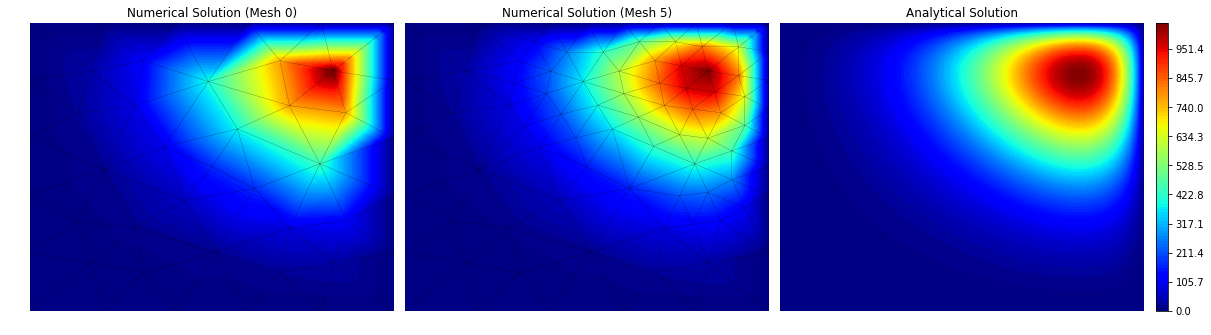

In [29]:



n_plot_vals = 50
x_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)
y_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)

# Initial Solution
x_plot_vals_init, y_plot_vals_init, u_plot_vals_init = mesh_init_obj.project_solution(x_plot_vals_1D, y_plot_vals_1D, n_plot_vals)

# Final Solution
x_plot_vals_final, y_plot_vals_final, u_plot_vals_final = mesh_obj.project_solution(x_plot_vals_1D, y_plot_vals_1D, n_plot_vals)

# Analytical Solution
x_plot_vals_analytical, y_plot_vals_analytical = x_plot_vals_init, y_plot_vals_init
u_analytical_plot_vals = u_analytical(x_plot_vals_analytical, y_plot_vals_analytical)


# Get common color bar
color_bar_max = max(np.max(u_plot_vals_init), np.max(u_plot_vals_final), np.max(u_analytical_plot_vals))
color_bar_min = min(np.min(u_plot_vals_init), np.min(u_plot_vals_final), np.min(u_analytical_plot_vals))
color_bar_levels = np.linspace(color_bar_min, color_bar_max, 100)

fig = plt.figure(figsize=(17, 5))

# Initial Solution Plot
plt.subplot(1,3,1)
plt.contourf(x_plot_vals_init, y_plot_vals_init, u_plot_vals_init, color_bar_levels, cmap=plt.get_cmap("jet"))
plt.title("Numerical Solution (Mesh 0)")
mesh_init_obj.plot_mesh(plot_nodes=False, linewidth=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().set_axis_off()

# Final Solution Plot
plt.subplot(1,3,2)
plt.contourf(x_plot_vals_final, y_plot_vals_final, u_plot_vals_final, color_bar_levels, cmap=plt.get_cmap("jet"))
plt.title("Numerical Solution (Mesh 5)")
mesh_obj.plot_mesh(plot_nodes=False, linewidth=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().set_axis_off()

# Analytical Solution
plt.subplot(1,3,3)
c = plt.contourf(x_plot_vals_analytical, y_plot_vals_analytical, u_analytical_plot_vals, color_bar_levels, cmap=plt.get_cmap("jet"))
plt.title("Analytical Solution")
plt.gca().set_axis_off()

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.01, right=0.92,
                    wspace=0.03, hspace=0.02)

cax = fig.add_axes([0.93, 0.1, 0.01, 0.8])
cbar = fig.colorbar(c, cax=cax)

#plt.savefig(CONST_plot_output_dir + "Initial_Final_Analytical_Solutions.png", dpi=300)


### Plot of $L_{\infty}$ Error Convergence

Plot the convergence in the $L_{\infty}$ norm of the error. Compare it to the results obtained for the case of uniform refinement.

[[25.0, 9.74112458505417], [49.0, 7.92028275855452], [102.0, 4.83794279131633], [232.0, 2.061362083137], [488.0, 1.27251806735177], [791.0, 0.778295004575847]]


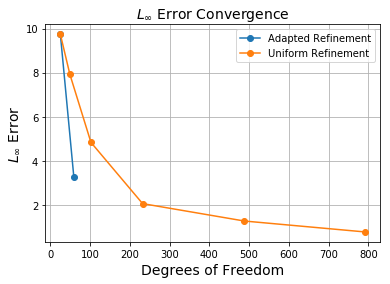

In [33]:

# Plot the Linf Error Convergence

ndof_vals = [x[0] for x in error_convergence_Linf]
linf_error_vals = [x[1] for x in error_convergence_Linf]

plt.plot(ndof_vals, linf_error_vals, marker="o", label="Adapted Refinement")

# Read the unadapted data convergence and plot it
unadapted_pts = []
with open("results/unadapted_sin_exp_case_convergence_Linf.txt", "r") as fp:
    while True:
        line = fp.readline()
        if line == "":
            break
        unadapted_pts.append([float(x) for x in line.rstrip("\n").split()])
        
plt.plot([x[0] for x in unadapted_pts], [x[1] for x in unadapted_pts], marker="o", label="Uniform Refinement")
        
plt.grid()
plt.legend()
plt.title(r"$L_{\infty}$ Error Convergence", fontsize=14)
plt.xlabel("Degrees of Freedom", fontsize=14)
plt.ylabel(r"$L_{\infty}$ Error", fontsize=14)